In [12]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../../..')))

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)
import json

# custom packages
from Models.Chaboche_Model.ChabocheModel import ChabocheModel
from Models.Chaboche_Model.ChabocheModel import chaboche_samples
from Models.Chaboche_Model.ChabocheModel import generate_model_evaluations

# Pointwise Sobol Indices

Using Pick and Freeze method

In [14]:
def pick_and_freeze(model, I, N, N_p, A, B):
    """
    Point-wise first and total order Sobol Indices

    Inputs:
        model = function that returns output of model for given input
                Input:  ndarray
                        [N, N_p]
                Output: [n_t, N]
                        Model evaluations for desired set of parameters
                        Each column has ouput of 1 set of parameters
        I = list or 1D array
            Indices in solution at which Sobol indices must be computed
        N = int
            number of MC samples
        N_p = int
              number of parameters
        A = ndarray
            First set of random inputs of size [N, N_p]
        B = ndarray
            Second set of random inputs of size [N, N_p]
        
    Outputs:
        S = ndarray
            [n, num_of_points] 
            num_of_points = len(num_of_points)
            First-order sensitivity of each the 'n' parameters
            at each I 

        S_T = ndarray
              [n,1]
              num_of_points = len(num_of_points)
              Total sensitivity of each the 'n' parameters
              at each I
    """

    def get_C_i(i):
        C_i = np.copy(B)
        C_i[:,i] = A[:,i]
        return C_i

    f_A = model(A) # [n_t, N] vector with evaluations at x_A
    f_B = model(B) # [n_t, N] vector with evaluations at x_B

    # store f_C
    f_C = np.zeros((f_A.shape[0], f_A.shape[1], N_p)) # [n_t, N, N_p] 3d array with evaluations at x_C_i

    for i in tqdm(range(N_p), desc = 'Computing f_C', ncols=100):
        f_C[:, :, i] = model(get_C_i(i)) # [n_t, N] vector with evaluations at x_C_i

    f_0 = np.mean(f_A, axis=1) # [n_t, 1] mean over N realisation for each discretisation point

    num_of_points = len(I)

    S = np.zeros((N_p, num_of_points))
    S_T = np.zeros((N_p, num_of_points))

    for j, time_index in enumerate(tqdm(I, desc = 'Computing Indices', ncols=100)):

        for i in range(N_p):
            f_A_local = f_A[time_index, :].T # [N, 1] vector
            f_B_local = f_B[time_index, :].T # [N, 1] vector
            f_C_local = f_C[time_index, :, i].T # [N, 1] vector
            f_0_local = f_0[time_index]

            # denominator is common in both terms
            # V[Y] = E[Y**2] - E[Y]**2
            total_variance = (np.dot(f_A_local, f_A_local)/N) - f_0_local**2

            # First order indices
            # Each column contains indices corresponding to a point in I
            S[i, j] = ( (np.dot(f_A_local, f_C_local)/N) - f_0_local**2 )  / ( total_variance )

            # Total indices
            # Each column contains indices corresponding to a point in I
            S_T[i, j] = 1 - ( (np.dot(f_B_local, f_C_local)/N - f_0_local**2) ) / ( total_variance )  

    return S, S_T, f_A, f_B, f_C

# Model

In [15]:
def chaboche_model_wrapper(parameters):
    """
    Wrapper to get function with signature:  model(A)

    Inputs:
    A : [N, 8] matrix
        0: Young's Modulus
        1: initial yield limit
        2: Q_iso
        3: b_iso
        4: n_iso
        5: sigma_D
        6: Q_kin
        7: b_kin
        Each column contains N realisations of each random variable  
        Each row contains one set of realisations

    Outputs:
        [N, 1] column vector
        N model evaluations
    """

    t_min = 0
    t_max = 2
    delta_t = 1e-3 # time step

    max_strain = 5e-2
    time_to_max_strain = 1

    model_object = ChabocheModel('1D', 'monotonic', max_strain, time_to_max_strain)

    output = generate_model_evaluations(model_object, t_min, t_max, delta_t, 'implicit', parameters, parallel_computation=True)

    return output

# Computation

In [16]:
N = int(10_000/2) # number of MC samples
N_p = 6 # number of parameters

X = chaboche_samples(2*N)

A1 = X[:N, :]
B1 = X[N:, :]

inspection_points = 101

# Time discretization
# divide [0,2] in inspection_points
t_min = 0
t_max = 2
delta_t = 1e-3 # time step
n = int((t_max-t_min)/delta_t) 
T = np.linspace(t_min, t_max, n +1)

I = np.linspace(10, n, inspection_points, dtype = int)

print(f'Total number of function evalutions = {N*(N_p+2)}')

S, S_T, f_A, f_B, f_C = pick_and_freeze(chaboche_model_wrapper, I, N, N_p, A1, B1)

Total number of function evalutions = 40000


Computing Indices: 100%|████████████████████████████████████████| 101/101 [00:00<00:00, 7836.05it/s]


# Plot

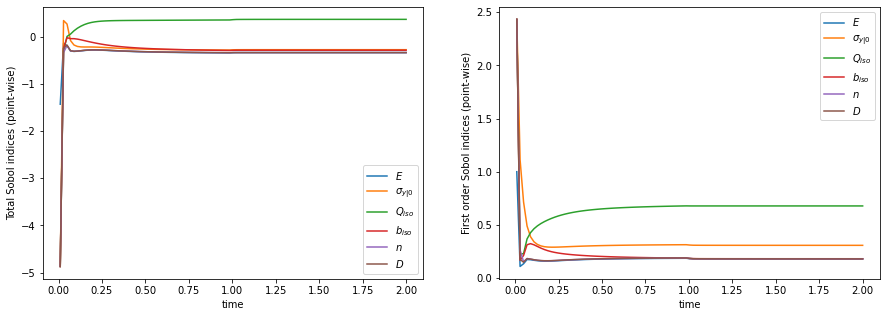

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T[I], S_T[0,:], '-', label = r'$E$')
ax[0].plot(T[I], S_T[1,:], '-', label = r'$\sigma_{y|0}$')
ax[0].plot(T[I], S_T[2,:], '-', label = r'$Q_{iso}$')
ax[0].plot(T[I], S_T[3,:], '-', label = r'$b_{iso}$')
ax[0].plot(T[I], S_T[4,:], '-', label = r'$n$')
ax[0].plot(T[I], S_T[5,:], '-', label = r'$D$')
ax[0].legend()
ax[0].set_xlabel('time')
ax[0].set_ylabel('Total Sobol indices (point-wise)')

ax[1].plot(T[I], S[0,:], '-', label = r'$E$')
ax[1].plot(T[I], S[1,:], '-', label = r'$\sigma_{y|0}$')
ax[1].plot(T[I], S[2,:], '-', label = r'$Q_{iso}$')
ax[1].plot(T[I], S[3,:], '-', label = r'$b_{iso}$')
ax[1].plot(T[I], S[4,:], '-', label = r'$n$')
ax[1].plot(T[I], S[5,:], '-', label = r'$D$')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('First order Sobol indices (point-wise)')

plt.show()

# Save model evaluations

In [8]:
# with open('model_vals_400_000.npy', 'wb') as f:
#     np.save(f, f_A)
#     np.save(f, f_B)
#     np.save(f, f_C)
#     np.save(f, S)
#     np.save(f, S_T)

In [ ]:
# model_evals = {
#             'f_A': f_A.tolist(),
#             'f_B': f_B.tolist(),
#             'f_C': f_C.tolist(),
#             'S'  : S.tolist(),
#             'S_T': S_T.tolist()
#             }

# with open('model_vals_5_float32.json', 'w') as f:
#     json.dump(model_evals, f)

# Read saved data

In [ ]:
# with open('model_vals_80_000.npy', 'rb') as f:
#     f_A = np.load(f)
#     f_B = np.load(f)
#     f_C = np.load(f)
#     S = np.load(f)
#     S_T = np.load(f)

In [19]:
with open('model_vals_80_000.json', 'r') as f:
    test_model_data = json.load(f)

In [ ]:
# I = np.linspace(0, n, 2001).astype(int)

# f_0 = np.mean(f_A, axis=1) # [n_t, 1] mean over N realisation for each discretisation point

# num_of_points = len(I)

# S = np.zeros((N_p, num_of_points))
# S_T = np.zeros((N_p, num_of_points))

# for j, time_index in enumerate(tqdm(I, desc = 'Computing Indices', ncols=100)):

#     for i in range(N_p):
#         f_A_local = f_A[time_index, :].T # [N, 1] vector
#         f_B_local = f_B[time_index, :].T # [N, 1] vector
#         f_C_local = f_C[time_index, :, i].T # [N, 1] vector
#         f_0_local = f_0[time_index]

#         # denominator is common in both terms
#         # V[Y] = E[Y**2] - E[Y]**2
#         total_variance = (np.dot(f_A_local, f_A_local)/N) - f_0_local**2

#         # First order indices
#         # Each column contains indices corresponding to a point in I
#         S[i, j] = ( (np.dot(f_A_local, f_C_local)/N) - f_0_local**2 )  / ( total_variance )

#         # Total indices
#         # Each column contains indices corresponding to a point in I
#         S_T[i, j] = 1 - ( (np.dot(f_B_local, f_C_local)/N - f_0_local**2) ) / ( total_variance )  

In [ ]:
# t_min = 0
# t_max = 2
# delta_t = 1e-3 # time step
# n = int((t_max-t_min)/delta_t) 
# T = np.linspace(t_min, t_max, n +1)

# inspection_points = 2001
# I = np.linspace(0, n, inspection_points).astype(int)

# S = np.array(test_model_data['S'])
# S_T =  np.array(test_model_data['S_T'])

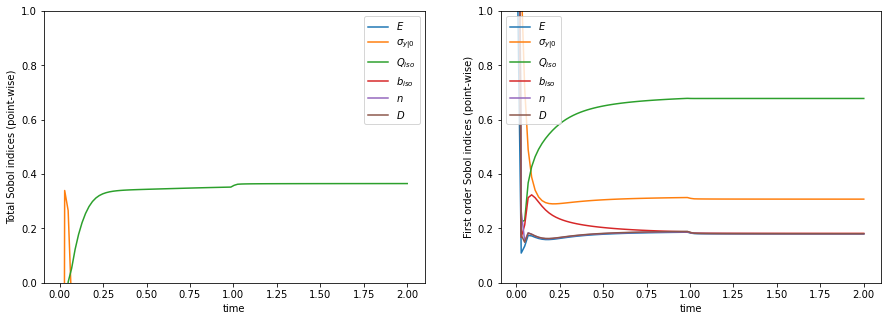

In [18]:
k = 0

fig, ax = plt.subplots(1, 2,figsize=(15,5))

ax[0].plot(T[I[k:]], S_T[0,k:], '-', label = r'$E$')
ax[0].plot(T[I[k:]], S_T[1,k:], '-', label = r'$\sigma_{y|0}$')
ax[0].plot(T[I[k:]], S_T[2,k:], '-', label = r'$Q_{iso}$')
ax[0].plot(T[I[k:]], S_T[3,k:], '-', label = r'$b_{iso}$')
ax[0].plot(T[I[k:]], S_T[4,k:], '-', label = r'$n$')
ax[0].plot(T[I[k:]], S_T[5,k:], '-', label = r'$D$')
ax[0].legend()
ax[0].set_ylim(0,1)
ax[0].set_xlabel('time')
ax[0].set_ylabel('Total Sobol indices (point-wise)')

ax[1].plot(T[I[k:]], S[0,k:], '-', label = r'$E$')
ax[1].plot(T[I[k:]], S[1,k:], '-', label = r'$\sigma_{y|0}$')
ax[1].plot(T[I[k:]], S[2,k:], '-', label = r'$Q_{iso}$')
ax[1].plot(T[I[k:]], S[3,k:], '-', label = r'$b_{iso}$')
ax[1].plot(T[I[k:]], S[4,k:], '-', label = r'$n$')
ax[1].plot(T[I[k:]], S[5,k:], '-', label = r'$D$')
ax[1].legend()
ax[1].set_ylim(0,1)
ax[1].set_xlabel('time')
ax[1].set_ylabel('First order Sobol indices (point-wise)')

plt.show()

In [25]:
# with open('model_vals_400_000.npy', 'rb') as f:
#     f_A_test = np.load(f)
#     f_B_test = np.load(f)
#     f_C_test = np.load(f)
#     S_test = np.load(f)
#     S_T_test = np.load(f)